In [1]:
import pandas as pd, numpy as np, geopandas as gpd, rasterio as rio

from rasterio.plot import show
from rasterio.mask import mask
import earthpy.plot as ep
import earthpy.spatial as es

import warnings
import matplotlib.pyplot as plt
from shapely.geometry import mapping
warnings.filterwarnings('ignore')

In [2]:
# Principal shp data  
shp_data = gpd.read_file("../data/0_shapefile/pos_gdf.shp").to_crs(epsg=4326)
shp_data.head(2)

,id_distr_b,year,newid,baseline_P,geometry
0,204,2015,3185,473,"POLYGON ((71.48246 34.14608, 71.48349 34.14576..."
1,203,2015,3185,472,"POLYGON ((71.48246 34.14608, 71.48349 34.14576..."


<Axes: >

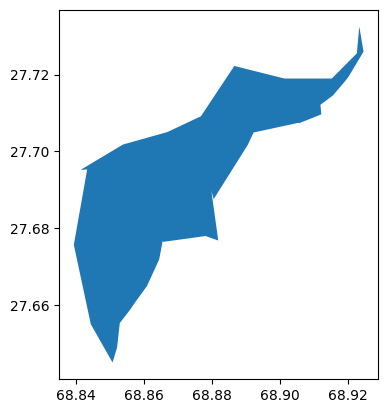

In [3]:
sample_shp = shp_data.sample(1, random_state=12)
sample_shp.plot()

In [4]:
shape=sample_shp.geometry.values[0]
geoms = [mapping(shape)]

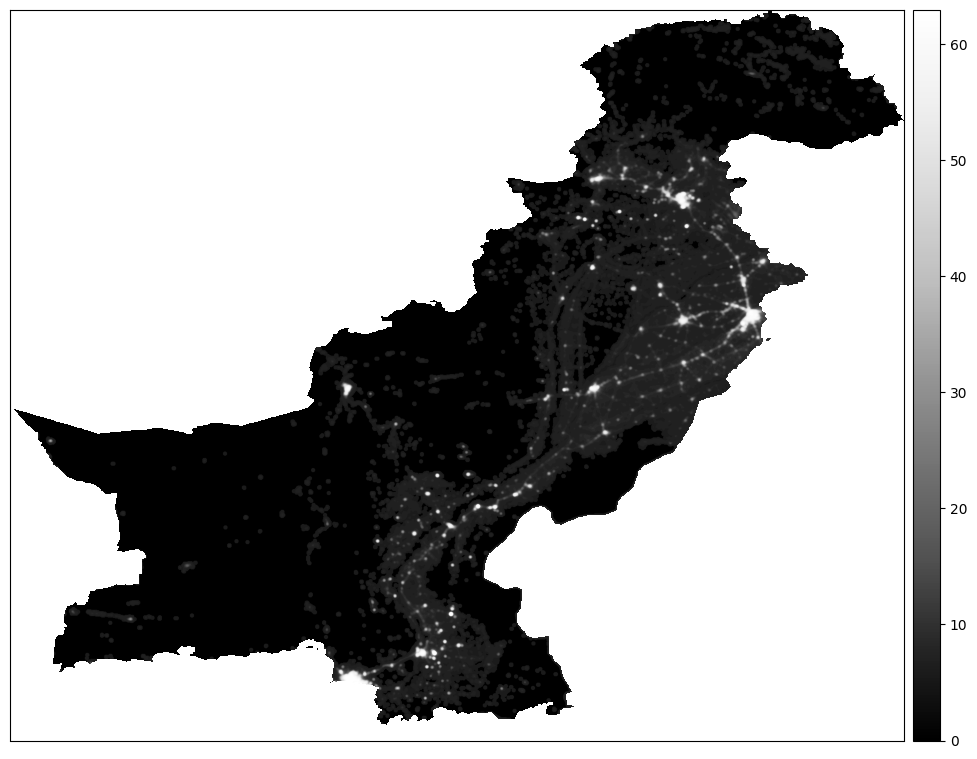

<Axes: >

In [5]:
# Test rasterfile
file_raster = "../data/8_night_light/pk_night_light_harm.tiff"

with rio.open(file_raster) as src:
    lidar_chm_im = src.read(masked=True)[0]
    soap_profile = src.profile
    extend = rio.plot.plotting_extent(src)

ep.plot_bands(lidar_chm_im)

In [6]:
soap_profile['crs'], sample_shp.crs

(CRS.from_epsg(4326),
 <Geographic 2D CRS: EPSG:4326>
 Name: WGS 84
 Axis Info [ellipsoidal]:
 - Lat[north]: Geodetic latitude (degree)
 - Lon[east]: Geodetic longitude (degree)
 Area of Use:
 - name: World.
 - bounds: (-180.0, -90.0, 180.0, 90.0)
 Datum: World Geodetic System 1984 ensemble
 - Ellipsoid: WGS 84
 - Prime Meridian: Greenwich)

In [7]:
with rio.open(file_raster) as src:
    lidar_chm_crop, soap_lidar_meta = es.crop_image(src, sample_shp)

<Axes: >

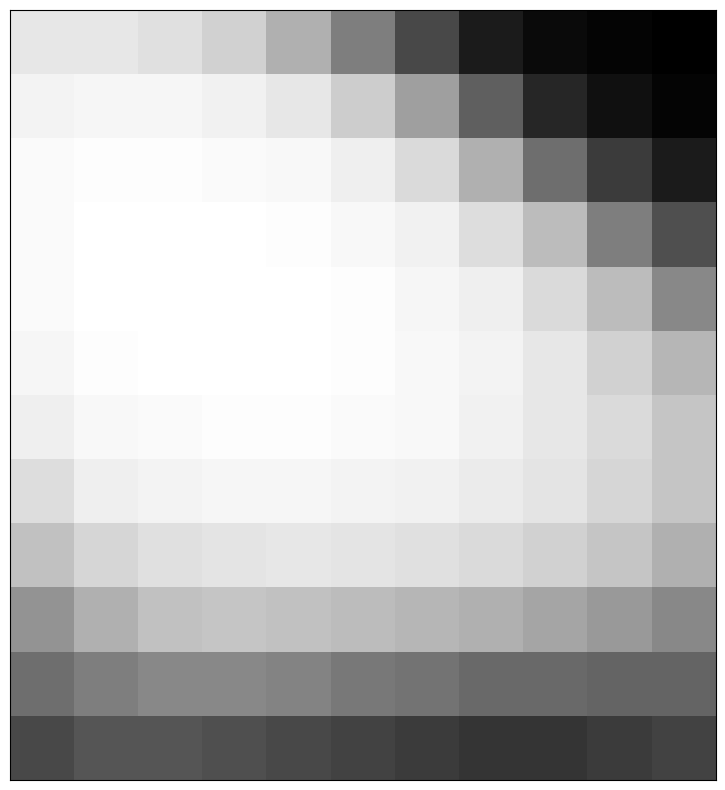

In [8]:
# ep.plot_bands(lidar_chm_crop)
fig, ax = plt.subplots(figsize = (10, 10))
sample_shp.plot(ax=ax, alpha = 1, color = 'g')
ep.plot_bands(lidar_chm_crop, ax=ax, cbar=False)
# crop

In [9]:
def getFeatures(gdf):
    """Function to parse features from GeoDataFrame in such a manner that rasterio wants them"""
    import json
    return [json.loads(gdf.to_json())['features'][0]['geometry']]


In [10]:
raster = rio.open(file_raster)
shapes = sample_shp.copy()

with rio.open(file_raster) as src:
    out_image, out_transform = mask(src, getFeatures(sample_shp) , crop = True)
values = out_image.flatten()
rows, cols = np.indices(out_image.shape[-2:])
x, y = rio.transform.xy(out_transform, rows.flatten(), cols.flatten())

# Crear un DataFrame con los valores y las coordenadas
data = {'x': x, 'y': y, 'z': values}
df = pd.DataFrame(data)
df.head(2)

,x,y,z
0,68.841666,27.733334,-3.400000e+38
1,68.849999,27.733334,-3.400000e+38


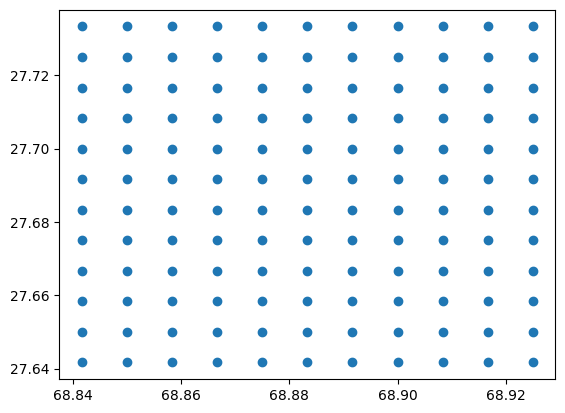

In [11]:
plt.scatter('x', 'y', data = df)

In [12]:
gdf_points = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df['x'], df['y'])).set_crs(epsg=4326)
points_inside = gpd.sjoin(gdf_points, sample_shp, how='inner', op = 'within')

<Axes: >

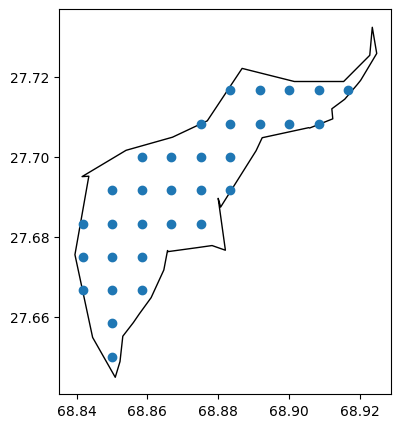

In [13]:
figs, ax = plt.subplots(figsize = (5, 5))
sample_shp.plot(ax = ax, color = 'white', edgecolor = 'black')
points_inside.plot(ax = ax)

# Using Personal Package

In [14]:
import sys
sys.path.append(r'D:\Workflow\dropbox\Dropbox\uc_ma_raster\python-ind-translate')

In [15]:
from src import user_function as utils 

df_cropped = utils.crop_raster(file_raster, sample_shp)
df_cropped = utils.points_inside(df_cropped, sample_shp)
utils.simple_metrics(df_cropped, target_name="nightlight_harm")

,id_distr_bank,year,newid,baseline_PSU,nightlight_harm_mean,nightlight_harm_sd,nightlight_harm_sum
27,242,2015,3192,344,50.65625,11.232469,1621.0


<Axes: >

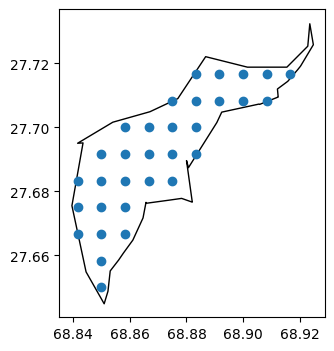

In [16]:
figs, ax = plt.subplots(figsize=(4, 4))
sample_shp.plot(ax= ax, color = "white", edgecolor='black')
df_cropped.plot(ax = ax)
